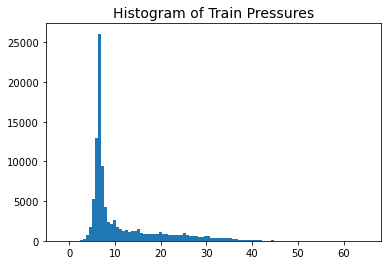

Max pressure = 64.8209917386395 Min pressure = -1.895744294564641
The first 25 unique pressures...


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
train_gf = pd.read_csv('./data/train.csv')

plt.title('Histogram of Train Pressures', size=14)
plt.hist(train_gf.sample(100_000).pressure, bins=100)
plt.show()
print('Max pressure =',train_gf.pressure.max(), 'Min pressure =',train_gf.pressure.min())

all_pressure = np.sort( train_gf.pressure.unique() )
print('The first 25 unique pressures...')
PRESSURE_MIN = all_pressure[0].item()
PRESSURE_MAX = all_pressure[-1].item()
PRESSURE_STEP = ( all_pressure[1] - all_pressure[0] ).item()

In [2]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/274717

import tensorflow as tf, gc
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
DEBUG = False
TRAIN_MODEL = False
FOLDS = [0, 1, 2, 3, 4]
EPOCH = 200
BATCH_SIZE = 256
if DEBUG:
    EPOCH = 2
    FOLDS = [0, 1]
NUM_FOLDS = len(FOLDS)

In [4]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_submission = pd.read_csv('./data/sample_submission.csv')

if DEBUG:
    df_train = df_train[:80*1000]

def add_features(df):
    df["dt"] = df.groupby('breath_id')['time_step'].shift(-1) - df['time_step']
    df["dt"].fillna((df["dt"].mean()), inplace=True)
    
    df['area'] = df['dt'] * df['u_in']
    df['area_p1'] = df.groupby('breath_id')['area'].shift(1)
    #df['area_p2'] = df.groupby('breath_id')['area'].shift(2)
    df['area_m1'] = df.groupby('breath_id')['area'].shift(-1)
    #df['area_m2'] = df.groupby('breath_id')['area'].shift(-2)
    df['area_tot'] = df.groupby('breath_id')['area'].cumsum()
    df['area_tot_p1'] = df.groupby('breath_id')['area_tot'].shift(1)
    #df['area_tot_p2'] = df.groupby('breath_id')['area_tot'].shift(2)
    df['area_tot_m1'] = df.groupby('breath_id')['area_tot'].shift(-1)
    #df['area_tot_m2'] = df.groupby('breath_id')['area_tot'].shift(-2)
    df = df.fillna(0)
    
    #df['area_weird'] = df['time_step'] * df['u_in']
    #df['area_weird'] = df.groupby('breath_id')['area_weird'].cumsum()
    df['u_in_cumsum'] = df.groupby('breath_id')['u_in'].cumsum()
    #df['breath_id__u_in__max'] = df.groupby('breath_id')['u_in'].transform('max')
    #df['breath_id__u_in__mean'] = df.groupby('breath_id')['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby('breath_id')['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby('breath_id')['u_in'].transform('mean') - df['u_in']
    
    df['u_in_p1'] = df.groupby('breath_id')['u_in'].shift(1)
    #df['u_in_p1'].fillna(method='bfill', inplace=True)
    df['u_in_p2'] = df.groupby('breath_id')['u_in_p1'].shift(1)
    #df['u_in_p2'].fillna(method='bfill', inplace=True)
    #df['u_in_p3'] = df.groupby('breath_id')['u_in_p2'].shift(1)
    #df['u_in_p3'].fillna(method='bfill', inplace=True)
    #df['u_in_p4'] = df.groupby('breath_id')['u_in_p3'].shift(1)
    #df['u_in_p4'].fillna(method='bfill', inplace=True)
    df['u_in_m1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_in_m2'] = df.groupby('breath_id')['u_in'].shift(-2)
    #df['u_in_m3'] = df.groupby('breath_id')['u_in'].shift(-3)
    #df['u_in_m4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df = df.fillna(0)
    
    df['u_in_diff1'] = df['u_in_m1'] - df['u_in']
    df['u_in_diff1_p1'] = df.groupby('breath_id')['u_in_diff1'].shift(1).fillna(0)
    #df['u_in_diff1_p2'] = df.groupby('breath_id')['u_in_diff1'].shift(2).fillna(0)
    df['u_in_diff1_m1'] = df.groupby('breath_id')['u_in_diff1'].shift(-1).fillna(0)
    #df['u_in_diff1_m2'] = df.groupby('breath_id')['u_in_diff1'].shift(-2).fillna(0)
    #df['u_in_diff2'] = df['u_in_m2'] - df['u_in']
    #df['u_in_diff3'] = df['u_in_m3'] - df['u_in']
    #df['u_in_diff4'] = df['u_in_m4'] - df['u_in']
    #df['u_in_derr1'] = df['u_in_diff1'] / df["dt"]
    
    #df['R'] = df['R'].astype(str)
    #df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df.drop(['R', 'C'], axis=1, inplace=True)
    df = pd.get_dummies(df)
    return df

df_train = add_features(df_train)
df_test = add_features(df_test)

In [5]:
display(df_train.head())

,id,breath_id,time_step,u_in,u_out,pressure,dt,area,area_p1,area_m1,area_tot,area_tot_p1,area_tot_m1,u_in_cumsum,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_p1,u_in_p2,u_in_m1,u_in_m2,u_in_diff1,u_in_diff1_p1,u_in_diff1_m1,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,1,0.000000,0.083334,0,5.837492,0.033652,0.002804,0.000000,0.622489,0.002804,0.000000,0.625293,0.083334,28.229702,10.062673,0.000000,0.000000,18.383041,22.509278,18.299707,0.000000,4.126236,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,0.033862,0.622489,0.002804,0.765942,0.625293,0.002804,1.391235,18.466375,9.929994,-8.237035,0.083334,0.000000,22.509278,22.808822,4.126236,18.299707,0.299544,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509278,0,7.876254,0.034028,0.765942,0.622489,0.780365,1.391235,0.625293,2.171600,40.975653,5.803758,-12.363271,18.383041,0.083334,22.808822,25.355850,0.299544,4.126236,2.547028,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808822,0,11.742872,0.034213,0.780365,0.765942,0.860634,2.171600,1.391235,3.032234,63.784476,5.504214,-12.662816,22.509278,18.383041,25.355850,27.259866,2.547028,0.299544,1.904016,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,0.033942,0.860634,0.780365,0.927113,3.032234,2.171600,3.959346,89.140326,2.957185,-15.209844,22.808822,22.509278,27.259866,27.127486,1.904016,2.547028,-0.132380,0,0,1,0,0,0,0,0,0


In [6]:
targets = df_train[['pressure']].to_numpy().reshape(-1, 80)
u_outs = df_train[['u_out']].to_numpy().reshape(-1, 80)
df_train.drop(['pressure', 'id', 'breath_id'], axis=1, inplace=True)
df_test.drop(['id', 'breath_id'], axis=1, inplace=True)

RS = RobustScaler()
train = RS.fit_transform(df_train)
test = RS.transform(df_test)

train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [7]:
display(df_train.head())

,time_step,u_in,u_out,dt,area,area_p1,area_m1,area_tot,area_tot_p1,area_tot_m1,u_in_cumsum,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_p1,u_in_p2,u_in_m1,u_in_m2,u_in_diff1,u_in_diff1_p1,u_in_diff1_m1,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,0.000000,0.083334,0,0.033652,0.002804,0.000000,0.622489,0.002804,0.000000,0.625293,0.083334,28.229702,10.062673,0.000000,0.000000,18.383041,22.509278,18.299707,0.000000,4.126236,0,0,1,0,0,0,0,0,0
1,0.033652,18.383041,0,0.033862,0.622489,0.002804,0.765942,0.625293,0.002804,1.391235,18.466375,9.929994,-8.237035,0.083334,0.000000,22.509278,22.808822,4.126236,18.299707,0.299544,0,0,1,0,0,0,0,0,0
2,0.067514,22.509278,0,0.034028,0.765942,0.622489,0.780365,1.391235,0.625293,2.171600,40.975653,5.803758,-12.363271,18.383041,0.083334,22.808822,25.355850,0.299544,4.126236,2.547028,0,0,1,0,0,0,0,0,0
3,0.101542,22.808822,0,0.034213,0.780365,0.765942,0.860634,2.171600,1.391235,3.032234,63.784476,5.504214,-12.662816,22.509278,18.383041,25.355850,27.259866,2.547028,0.299544,1.904016,0,0,1,0,0,0,0,0,0
4,0.135756,25.355850,0,0.033942,0.860634,0.780365,0.927113,3.032234,2.171600,3.959346,89.140326,2.957185,-15.209844,22.808822,22.509278,27.259866,27.127486,1.904016,2.547028,-0.132380,0,0,1,0,0,0,0,0,0


In [8]:
def GBVPP_loss(y_true, y_pred, cols=80):
    u_out = y_true[:, cols:]
    y = y_true[:, :cols]
    w = 1 - u_out
    mae = w * tf.abs(y - y_pred)
    return tf.reduce_sum(mae, axis=-1) / tf.reduce_sum(w, axis=-1)

#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#strategy = tf.distribute.experimental.TPUStrategy(tpu)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
strategy = tf.distribute.get_strategy()  # gpu

tf.keras.backend.clear_session()
with strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    history_arr = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        K.clear_session()
        
        print('-'*15, '>', f'Fold {FOLDS[fold]}', '<', '-'*15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        u_out_train, u_out_valid = u_outs[train_idx], u_outs[test_idx] 
        
        checkpoint_filepath = f"folds{FOLDS[fold]}.hdf5"
        if TRAIN_MODEL:
            inputs = keras.layers.Input(shape=train.shape[-2:])
            
            """
            layer1 = keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences=True, dropout=0.0))(inputs)
            layer2 = keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True, dropout=0.0))(layer1)
            layer3 = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True, dropout=0.0))(layer2)
            layer4 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.0))(layer3)
            layer5 = keras.layers.Dense(128, activation='selu')(layer4)
            """
            
            #"""
            #layer1 = keras.layers.Bidirectional(keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(800, input_shape=train.shape[-2:], dropout=0.0),
            #                                                     return_sequences=True))(inputs)
            layer2 = keras.layers.Bidirectional(keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(400, input_shape=train.shape[-2:], dropout=0.0),
                                                                 return_sequences=True))(inputs)
            layer3 = keras.layers.Bidirectional(keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(200, input_shape=train.shape[-2:], dropout=0.0),
                                                                 return_sequences=True))(layer2)
            layer4 = keras.layers.Bidirectional(keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(100, input_shape=train.shape[-2:], dropout=0.0),
                                                                 return_sequences=True))(layer3)
            layer5 = keras.layers.Dense(100, activation='selu')(layer4)
            #"""
            
            preds = keras.layers.Dense(1)(layer5)
            model = keras.Model(inputs=inputs, outputs=preds)
            
            #model.compile(optimizer="adam", loss="mean_absolute_error")
            model.compile(optimizer="adam", loss=GBVPP_loss)

            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)
            sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            history = model.fit(X_train, np.append(y_train, u_out_train, axis=1),
                                validation_data=(X_valid, np.append(y_valid, u_out_valid, axis=1)),
                                epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr, es, sv])
        else:
            model = keras.models.load_model('./'+checkpoint_filepath)
            
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE, verbose=2).squeeze().reshape(-1, 1).squeeze())
        history_arr.append(history)
        del model, X_train, X_valid; gc.collect()

--------------- > Fold 0 < ---------------
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. Wh

236/236 [==============================] - 207s 876ms/step - loss: 0.3232 - val_loss: 0.3147

Epoch 00038: val_loss did not improve from 0.29129
Epoch 39/200
236/236 [==============================] - 199s 842ms/step - loss: 0.2991 - val_loss: 0.3249

Epoch 00039: val_loss did not improve from 0.29129
Epoch 40/200
236/236 [==============================] - 192s 815ms/step - loss: 0.3054 - val_loss: 0.4454

Epoch 00040: val_loss did not improve from 0.29129
Epoch 41/200
236/236 [==============================] - 192s 814ms/step - loss: 0.3705 - val_loss: 0.3448

Epoch 00041: val_loss did not improve from 0.29129
Epoch 42/200
236/236 [==============================] - 190s 806ms/step - loss: 0.3065 - val_loss: 0.3174

Epoch 00042: val_loss did not improve from 0.29129
Epoch 43/200
236/236 [==============================] - 191s 811ms/step - loss: 0.2789 - val_loss: 0.2901

Epoch 00043: val_loss improved from 0.29129 to 0.29014, saving model to folds0.hdf5
Epoch 44/200
236/236 [==========

236/236 [==============================] - 190s 806ms/step - loss: 0.1368 - val_loss: 0.2077

Epoch 00087: val_loss did not improve from 0.20056
Epoch 88/200
236/236 [==============================] - 191s 810ms/step - loss: 0.1374 - val_loss: 0.2082

Epoch 00088: val_loss did not improve from 0.20056
Epoch 89/200
236/236 [==============================] - 193s 819ms/step - loss: 0.1539 - val_loss: 0.2049

Epoch 00089: val_loss did not improve from 0.20056
Epoch 90/200
236/236 [==============================] - 191s 811ms/step - loss: 0.1456 - val_loss: 0.2075

Epoch 00090: val_loss did not improve from 0.20056
Epoch 91/200
236/236 [==============================] - 191s 808ms/step - loss: 0.1436 - val_loss: 0.1993

Epoch 00091: val_loss improved from 0.20056 to 0.19927, saving model to folds0.hdf5
Epoch 92/200
236/236 [==============================] - 192s 813ms/step - loss: 0.1301 - val_loss: 0.2028

Epoch 00092: val_loss did not improve from 0.19927
Epoch 93/200
236/236 [==========

236/236 [==============================] - 189s 802ms/step - loss: 0.0846 - val_loss: 0.1762

Epoch 00135: val_loss did not improve from 0.17501
Epoch 136/200
236/236 [==============================] - 189s 801ms/step - loss: 0.0853 - val_loss: 0.1749

Epoch 00136: val_loss improved from 0.17501 to 0.17488, saving model to folds0.hdf5
Epoch 137/200
236/236 [==============================] - 189s 800ms/step - loss: 0.0846 - val_loss: 0.1759

Epoch 00137: val_loss did not improve from 0.17488
Epoch 138/200
236/236 [==============================] - 189s 799ms/step - loss: 0.0878 - val_loss: 0.1747

Epoch 00138: val_loss improved from 0.17488 to 0.17470, saving model to folds0.hdf5
Epoch 139/200
236/236 [==============================] - 189s 800ms/step - loss: 0.0841 - val_loss: 0.1755

Epoch 00139: val_loss did not improve from 0.17470
Epoch 140/200
236/236 [==============================] - 189s 799ms/step - loss: 0.0842 - val_loss: 0.1745

Epoch 00140: val_loss improved from 0.17470 t


Epoch 00183: val_loss did not improve from 0.16915
Epoch 184/200
236/236 [==============================] - 188s 799ms/step - loss: 0.0637 - val_loss: 0.1695

Epoch 00184: val_loss did not improve from 0.16915
Epoch 185/200
236/236 [==============================] - 188s 798ms/step - loss: 0.0634 - val_loss: 0.1697

Epoch 00185: val_loss did not improve from 0.16915
Epoch 186/200
236/236 [==============================] - 190s 805ms/step - loss: 0.0625 - val_loss: 0.1704

Epoch 00186: val_loss did not improve from 0.16915
Epoch 187/200
236/236 [==============================] - 188s 797ms/step - loss: 0.0622 - val_loss: 0.1698

Epoch 00187: val_loss did not improve from 0.16915
Epoch 188/200
236/236 [==============================] - 188s 796ms/step - loss: 0.0624 - val_loss: 0.1696

Epoch 00188: val_loss did not improve from 0.16915
Epoch 189/200
236/236 [==============================] - 188s 795ms/step - loss: 0.0620 - val_loss: 0.1697

Epoch 00189: val_loss did not improve from 0.

236/236 [==============================] - 187s 794ms/step - loss: 0.3544 - val_loss: 0.4177

Epoch 00031: val_loss did not improve from 0.36392
Epoch 32/200
236/236 [==============================] - 187s 795ms/step - loss: 0.3521 - val_loss: 0.4666

Epoch 00032: val_loss did not improve from 0.36392
Epoch 33/200
236/236 [==============================] - 187s 793ms/step - loss: 0.3838 - val_loss: 0.4314

Epoch 00033: val_loss did not improve from 0.36392
Epoch 34/200
236/236 [==============================] - 198s 841ms/step - loss: 0.3306 - val_loss: 0.3321

Epoch 00034: val_loss improved from 0.36392 to 0.33212, saving model to folds1.hdf5
Epoch 35/200
236/236 [==============================] - 210s 889ms/step - loss: 0.3208 - val_loss: 0.3210

Epoch 00035: val_loss improved from 0.33212 to 0.32096, saving model to folds1.hdf5
Epoch 36/200
236/236 [==============================] - 205s 871ms/step - loss: 0.3058 - val_loss: 0.3277

Epoch 00036: val_loss did not improve from 0.32096

236/236 [==============================] - 193s 816ms/step - loss: 0.1806 - val_loss: 0.2464

Epoch 00080: val_loss did not improve from 0.23982
Epoch 81/200
236/236 [==============================] - 194s 823ms/step - loss: 0.1982 - val_loss: 0.2520

Epoch 00081: val_loss did not improve from 0.23982
Epoch 82/200
236/236 [==============================] - 194s 820ms/step - loss: 0.1759 - val_loss: 0.2403

Epoch 00082: val_loss did not improve from 0.23982
Epoch 83/200
236/236 [==============================] - 197s 834ms/step - loss: 0.2000 - val_loss: 0.2429

Epoch 00083: val_loss did not improve from 0.23982
Epoch 84/200
236/236 [==============================] - 195s 828ms/step - loss: 0.1828 - val_loss: 0.2489

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00084: val_loss did not improve from 0.23982
Epoch 85/200
236/236 [==============================] - 196s 831ms/step - loss: 0.1546 - val_loss: 0.2154

Epoch 00085: val_loss improved from

236/236 [==============================] - 199s 841ms/step - loss: 0.0865 - val_loss: 0.1883

Epoch 00128: val_loss improved from 0.18919 to 0.18827, saving model to folds1.hdf5
Epoch 129/200
236/236 [==============================] - 196s 831ms/step - loss: 0.0858 - val_loss: 0.1882

Epoch 00129: val_loss improved from 0.18827 to 0.18818, saving model to folds1.hdf5
Epoch 130/200
236/236 [==============================] - 197s 834ms/step - loss: 0.0849 - val_loss: 0.1882

Epoch 00130: val_loss did not improve from 0.18818
Epoch 131/200
236/236 [==============================] - 195s 827ms/step - loss: 0.0841 - val_loss: 0.1891

Epoch 00131: val_loss did not improve from 0.18818
Epoch 132/200
236/236 [==============================] - 195s 826ms/step - loss: 0.0835 - val_loss: 0.1876

Epoch 00132: val_loss improved from 0.18818 to 0.18761, saving model to folds1.hdf5
Epoch 133/200
236/236 [==============================] - 197s 836ms/step - loss: 0.0842 - val_loss: 0.1883

Epoch 00133:

236/236 [==============================] - 191s 810ms/step - loss: 0.0615 - val_loss: 0.1830

Epoch 00176: val_loss did not improve from 0.18266
Epoch 177/200
236/236 [==============================] - 191s 811ms/step - loss: 0.0613 - val_loss: 0.1831

Epoch 00177: val_loss did not improve from 0.18266
Epoch 178/200
236/236 [==============================] - 198s 838ms/step - loss: 0.0601 - val_loss: 0.1831

Epoch 00178: val_loss did not improve from 0.18266
Epoch 179/200
236/236 [==============================] - 195s 825ms/step - loss: 0.0607 - val_loss: 0.1829

Epoch 00179: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00179: val_loss did not improve from 0.18266
Epoch 180/200
236/236 [==============================] - 198s 837ms/step - loss: 0.0589 - val_loss: 0.1827

Epoch 00180: val_loss did not improve from 0.18266
Epoch 181/200
236/236 [==============================] - 198s 839ms/step - loss: 0.0587 - val_loss: 0.1828

Epoch 00181: val_loss did not 

236/236 [==============================] - 189s 801ms/step - loss: 0.3483 - val_loss: 0.3677

Epoch 00024: val_loss improved from 0.38850 to 0.36774, saving model to folds2.hdf5
Epoch 25/200
236/236 [==============================] - 189s 801ms/step - loss: 0.3417 - val_loss: 0.3798

Epoch 00025: val_loss did not improve from 0.36774
Epoch 26/200
236/236 [==============================] - 189s 802ms/step - loss: 0.3307 - val_loss: 0.3596

Epoch 00026: val_loss improved from 0.36774 to 0.35960, saving model to folds2.hdf5
Epoch 27/200
236/236 [==============================] - 189s 799ms/step - loss: 0.3510 - val_loss: 0.3503

Epoch 00027: val_loss improved from 0.35960 to 0.35026, saving model to folds2.hdf5
Epoch 28/200
236/236 [==============================] - 190s 804ms/step - loss: 0.3284 - val_loss: 0.4056

Epoch 00028: val_loss did not improve from 0.35026
Epoch 29/200
236/236 [==============================] - 189s 800ms/step - loss: 0.3585 - val_loss: 0.3333

Epoch 00029: val_

236/236 [==============================] - 203s 858ms/step - loss: 0.1423 - val_loss: 0.2007

Epoch 00071: val_loss improved from 0.20222 to 0.20072, saving model to folds2.hdf5
Epoch 72/200
236/236 [==============================] - 202s 857ms/step - loss: 0.1454 - val_loss: 0.2152

Epoch 00072: val_loss did not improve from 0.20072
Epoch 73/200
236/236 [==============================] - 200s 850ms/step - loss: 0.1405 - val_loss: 0.2101

Epoch 00073: val_loss did not improve from 0.20072
Epoch 74/200
236/236 [==============================] - 199s 843ms/step - loss: 0.1383 - val_loss: 0.1998

Epoch 00074: val_loss improved from 0.20072 to 0.19976, saving model to folds2.hdf5
Epoch 75/200
236/236 [==============================] - 195s 825ms/step - loss: 0.1378 - val_loss: 0.2057

Epoch 00075: val_loss did not improve from 0.19976
Epoch 76/200
236/236 [==============================] - 199s 845ms/step - loss: 0.1404 - val_loss: 0.2044

Epoch 00076: val_loss did not improve from 0.19976

236/236 [==============================] - 192s 813ms/step - loss: 0.0968 - val_loss: 0.1815

Epoch 00119: val_loss did not improve from 0.17993
Epoch 120/200
236/236 [==============================] - 191s 812ms/step - loss: 0.0916 - val_loss: 0.1772

Epoch 00120: val_loss improved from 0.17993 to 0.17717, saving model to folds2.hdf5
Epoch 121/200
236/236 [==============================] - 192s 813ms/step - loss: 0.0900 - val_loss: 0.1793

Epoch 00121: val_loss did not improve from 0.17717
Epoch 122/200
236/236 [==============================] - 191s 809ms/step - loss: 0.0908 - val_loss: 0.1794

Epoch 00122: val_loss did not improve from 0.17717
Epoch 123/200
236/236 [==============================] - 191s 809ms/step - loss: 0.0901 - val_loss: 0.1786

Epoch 00123: val_loss did not improve from 0.17717
Epoch 124/200
236/236 [==============================] - 191s 808ms/step - loss: 0.0895 - val_loss: 0.1793

Epoch 00124: val_loss did not improve from 0.17717
Epoch 125/200
236/236 [====

236/236 [==============================] - 188s 797ms/step - loss: 0.0626 - val_loss: 0.1721

Epoch 00168: val_loss did not improve from 0.17205
Epoch 169/200
236/236 [==============================] - 188s 797ms/step - loss: 0.0614 - val_loss: 0.1721

Epoch 00169: val_loss did not improve from 0.17205
Epoch 170/200
236/236 [==============================] - 189s 799ms/step - loss: 0.0614 - val_loss: 0.1720

Epoch 00170: val_loss improved from 0.17205 to 0.17200, saving model to folds2.hdf5
Epoch 171/200
236/236 [==============================] - 188s 798ms/step - loss: 0.0618 - val_loss: 0.1721

Epoch 00171: val_loss did not improve from 0.17200
Epoch 172/200
236/236 [==============================] - 188s 797ms/step - loss: 0.0620 - val_loss: 0.1721

Epoch 00172: val_loss did not improve from 0.17200
Epoch 173/200
236/236 [==============================] - 188s 798ms/step - loss: 0.0624 - val_loss: 0.1722

Epoch 00173: val_loss did not improve from 0.17200
Epoch 174/200
236/236 [====

236/236 [==============================] - 187s 794ms/step - loss: 0.4761 - val_loss: 0.4365

Epoch 00016: val_loss improved from 0.47403 to 0.43648, saving model to folds3.hdf5
Epoch 17/200
236/236 [==============================] - 187s 793ms/step - loss: 0.4460 - val_loss: 0.4209

Epoch 00017: val_loss improved from 0.43648 to 0.42092, saving model to folds3.hdf5
Epoch 18/200
236/236 [==============================] - 188s 794ms/step - loss: 0.4227 - val_loss: 0.4222

Epoch 00018: val_loss did not improve from 0.42092
Epoch 19/200
236/236 [==============================] - 187s 794ms/step - loss: 0.3852 - val_loss: 0.4090

Epoch 00019: val_loss improved from 0.42092 to 0.40904, saving model to folds3.hdf5
Epoch 20/200
236/236 [==============================] - 188s 796ms/step - loss: 0.4271 - val_loss: 0.4734

Epoch 00020: val_loss did not improve from 0.40904
Epoch 21/200
236/236 [==============================] - 188s 795ms/step - loss: 0.4167 - val_loss: 0.3932

Epoch 00021: val_

236/236 [==============================] - 187s 793ms/step - loss: 0.2524 - val_loss: 0.3067

Epoch 00065: val_loss did not improve from 0.25624
Epoch 66/200
236/236 [==============================] - 187s 792ms/step - loss: 0.2404 - val_loss: 0.3313

Epoch 00066: val_loss did not improve from 0.25624
Epoch 67/200
236/236 [==============================] - 187s 794ms/step - loss: 0.2592 - val_loss: 0.2581

Epoch 00067: val_loss did not improve from 0.25624
Epoch 68/200
236/236 [==============================] - 188s 795ms/step - loss: 0.2287 - val_loss: 0.2559

Epoch 00068: val_loss improved from 0.25624 to 0.25587, saving model to folds3.hdf5
Epoch 69/200
236/236 [==============================] - 187s 792ms/step - loss: 0.2217 - val_loss: 0.2711

Epoch 00069: val_loss did not improve from 0.25587
Epoch 70/200
236/236 [==============================] - 187s 793ms/step - loss: 0.2657 - val_loss: 0.2584

Epoch 00070: val_loss did not improve from 0.25587
Epoch 71/200
236/236 [==========

236/236 [==============================] - 188s 797ms/step - loss: 0.1251 - val_loss: 0.1938

Epoch 00114: val_loss did not improve from 0.19191
Epoch 115/200
236/236 [==============================] - 190s 803ms/step - loss: 0.1180 - val_loss: 0.1920

Epoch 00115: val_loss did not improve from 0.19191
Epoch 116/200
236/236 [==============================] - 197s 837ms/step - loss: 0.1338 - val_loss: 0.1890

Epoch 00116: val_loss improved from 0.19191 to 0.18897, saving model to folds3.hdf5
Epoch 117/200
236/236 [==============================] - 206s 873ms/step - loss: 0.1117 - val_loss: 0.1975

Epoch 00117: val_loss did not improve from 0.18897
Epoch 118/200
236/236 [==============================] - 269s 1s/step - loss: 0.1649 - val_loss: 0.1969

Epoch 00118: val_loss did not improve from 0.18897
Epoch 119/200
236/236 [==============================] - 204s 863ms/step - loss: 0.1172 - val_loss: 0.2010

Epoch 00119: val_loss did not improve from 0.18897
Epoch 120/200
236/236 [=======

236/236 [==============================] - 188s 795ms/step - loss: 0.0777 - val_loss: 0.1737

Epoch 00163: val_loss did not improve from 0.17369
Epoch 164/200
236/236 [==============================] - 187s 794ms/step - loss: 0.0834 - val_loss: 0.1746

Epoch 00164: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00164: val_loss did not improve from 0.17369
Epoch 165/200
236/236 [==============================] - 187s 794ms/step - loss: 0.0745 - val_loss: 0.1707

Epoch 00165: val_loss improved from 0.17369 to 0.17073, saving model to folds3.hdf5
Epoch 166/200
236/236 [==============================] - 187s 794ms/step - loss: 0.0774 - val_loss: 0.1750

Epoch 00166: val_loss did not improve from 0.17073
Epoch 167/200
236/236 [==============================] - 188s 796ms/step - loss: 0.0735 - val_loss: 0.1749

Epoch 00167: val_loss did not improve from 0.17073
Epoch 168/200
236/236 [==============================] - 187s 794ms/step - loss: 0.0717 - val_loss: 0.171


Epoch 00009: val_loss improved from 0.51864 to 0.50024, saving model to folds4.hdf5
Epoch 10/200
236/236 [==============================] - 188s 796ms/step - loss: 0.4831 - val_loss: 0.5225

Epoch 00010: val_loss did not improve from 0.50024
Epoch 11/200
236/236 [==============================] - 188s 797ms/step - loss: 0.4866 - val_loss: 0.4649

Epoch 00011: val_loss improved from 0.50024 to 0.46494, saving model to folds4.hdf5
Epoch 12/200
236/236 [==============================] - 188s 795ms/step - loss: 0.4532 - val_loss: 0.4464

Epoch 00012: val_loss improved from 0.46494 to 0.44644, saving model to folds4.hdf5
Epoch 13/200
236/236 [==============================] - 188s 798ms/step - loss: 0.4316 - val_loss: 0.5863

Epoch 00013: val_loss did not improve from 0.44644
Epoch 14/200
236/236 [==============================] - 188s 795ms/step - loss: 0.4879 - val_loss: 0.4475

Epoch 00014: val_loss did not improve from 0.44644
Epoch 15/200
236/236 [==============================] - 190

KeyboardInterrupt: 

In [10]:
# ENSEMBLE FOLDS WITH MEAN
df_submission["pressure"] = sum(test_preds) / len(test_preds)
df_submission.to_csv('submission_mean_LB157.csv', index=False)

# ENSEMBLE FOLDS WITH MEDIAN
df_submission["pressure"] = np.median(np.vstack(test_preds), axis=0)
df_submission.to_csv('submission_median_LB155.csv', index=False)

# ENSEMBLE FOLDS WITH MEDIAN AND ROUND PREDICTIONS
df_submission["pressure"] = np.round( (df_submission.pressure - PRESSURE_MIN) / PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN
df_submission.pressure = np.clip(df_submission.pressure, PRESSURE_MIN, PRESSURE_MAX)
df_submission.to_csv('submission_median_round_LB153.csv', index=False)